In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

In [113]:
df= pd.read_csv('credit-card-default.csv')

In [114]:
df = df.drop(['ID'], axis =1)
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
df = pd.get_dummies(df, columns= cat_cols, drop_first = True)

In [115]:
y = df['defaulted']
X = df.drop('defaulted', axis =1)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

In [116]:
Best_Parameters= {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 100, 'max_depth': 8}

In [117]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(**Best_Parameters)

rf.fit(X_train,y_train )



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [118]:
y_train_pred = rf.predict(X_train)
y_train_prob = rf.predict_proba(X_train)[:,1]

print(confusion_matrix(y_train, y_train_pred))
print('ROC AUC of Train Data:',roc_auc_score(y_train, y_train_prob))

[[15648   676]
 [ 3103  1573]]
ROC AUC of Train Data: 0.7976588916192189


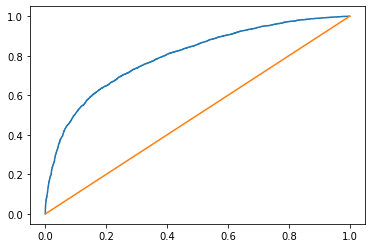

In [119]:
fpr, tpr, threshold = roc_curve(y_train, y_train_prob)
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)

In [120]:
y_test_pred = rf.predict(X_test)
y_test_prob = rf.predict_proba(X_test)[:,1]

print(confusion_matrix(y_test, y_test_pred))
print('ROC AUC of Train Data:',roc_auc_score(y_test, y_test_prob))

[[6734  306]
 [1348  612]]
ROC AUC of Train Data: 0.7741954864332097


Text(0, 0.5, 'TPR')

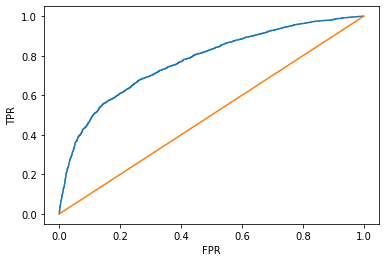

In [121]:
fpr, tpr, threshold = roc_curve(y_test, y_test_prob)
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

### If we assume that cost of wrong prediction of defaulters is same as cost of wrong prediction of non-defaulters. 
### Then optimal cutoff is where the difference of FPR and TPR is maximum

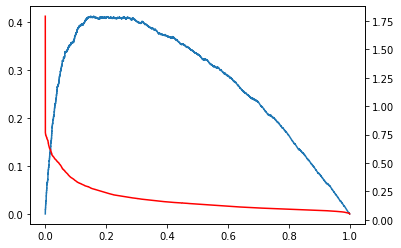

In [28]:
fig , ax1 = plt.subplots()
ax1.plot(fpr, tpr-fpr)

ax2 = ax1.twinx()
ax2.plot(fpr, threshold, 'r')

In [29]:
optimal_idx = np.argmax(tpr-fpr)

In [30]:
optimal_threshold = threshold[optimal_idx]
optimal_threshold

0.27056070778420155

# Predicting the defaulters in new data set

In [97]:
df = pd.read_csv('credit-card-default.csv')

In [98]:
df.shape

(30000, 25)

In [99]:
df.drop('defaulted', axis=1, inplace=True)

In [100]:
dfts = pd.read_csv('credit-card-default_toscore.csv')

In [101]:
dfall = pd.concat([df,dfts], axis=0)

cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
dfall = pd.get_dummies(dfall, columns= cat_cols, drop_first = True)
dfts = dfall.iloc[30000:,]

In [102]:
ID = dfts[['ID']]

In [103]:
dfts.drop(['ID'], axis=1, inplace=True)

In [104]:
dfts_prob = rf.predict_proba(dfts)[:,1]

In [105]:
ID['prob'] = dfts_prob

In [109]:
ID = ID[ID['prob']>0.27]

In [110]:
ID 


,ID,prob
0,0,0.532739
22,22,0.352148
25,25,0.729226
32,32,0.404092
34,34,0.544895
35,35,0.346824
40,40,0.272619
42,42,0.287968
43,43,0.487900
45,45,0.292955


# ------------------- List of Customers likely to default finish   ---------------------

In [111]:
## In most situations, cost of a defaulter is much longer than 
# the benefit of a non - defaulter. Hence, the previous assumption is weak.
# In the next excercise, we will consider the cost and benefit
# of all the possible cases

In [123]:
gain = []
i_vals = []

pred = rf.predict(X_train)

for i in np.linspace(0,0.8,50):
    rf.fit(X_train, y_train)
    y_prob = rf.predict_proba(X_train)
    y_prob = pd.DataFrame(y_prob)
    y_pred = y_prob[1].apply(lambda x:1 if x>i else 0)
    conf = confusion_matrix(y_train, y_pred)
    
    total_benefit = conf[0][0]*75 - conf[0][1]*75 - conf[1][0]*200 +conf[1][1]*200
    gain.append(total_benefit)
    i_vals.append(i)
    
print('maximum gain :', max(gain))

maximum gain : 1037450


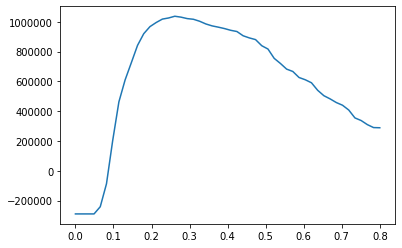

In [124]:
plt.plot(i_vals, gain)

From the above graph it can be seen that the optimum value for threshold for the highest gain is near to 0.25 and in the confusion matrix also we predicted that the optimum value of threshold was 0.27 (tpr - fpr , indexing).
therefore, it can be concluded that the best threshold is near to 0.25.